## Undersampling dataset

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=128): # khởi tạo dataset
        self.df = pd.read_csv(csv_file) # đọc file csv
        self.df = self.df.dropna(subset=['clean_text', 'stars']) # xoá dòng null
        self.tokenizer = tokenizer
        self.max_len = max_len # độ dài tối đa của chuỗi đầu vào

    def __len__(self):
        return len(self.df) # trả về độ dài dataset

    def __getitem__(self, index):
        text = str(self.df.loc[index, 'clean_text']) # ép kiểu về str
        score = float(self.df.loc[index, 'stars']) # ép kiểu về float

        encoding = self.tokenizer.encode_plus(
            text, # chuỗi cần mã hoá
            add_special_tokens=True, # thêm token đặc biệt [CLS], [SEP] để Bert hiểu và bắt đầu phân loại
            max_length=self.max_len, # độ dài tối đa
            return_token_type_ids=False, # không trả về token type ids vì chỉ có một câu
            padding='max_length', # bổ sung dữ liệu nếu chuỗi ngắn hơn độ dài tối đa
            truncation=True, # cắt bớt dữ liệu nếu chuỗi dài hơn độ dài tối đa
            return_attention_mask=True, # trả về attention mask để Bert biết phần nào là dữ liệu thực, phần nào là padding
            return_tensors='pt', # trả về dưới dạng tensor của PyTorch
        )

        return { 
            'input_ids': encoding['input_ids'].flatten(), # flatten() để chuyển từ tensor 2D sang 1D
            'attention_mask': encoding['attention_mask'].flatten(), # flatten() để chuyển từ tensor 2D sang 1D
            'targets': torch.tensor(score, dtype=torch.float) # chuyển score về tensor float
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') # sử dụng tokenizer của BERT

# Load Data 
train_dataset = ReviewDataset('Undersampling/train_undersample.csv', tokenizer)
test_dataset = ReviewDataset('test.csv', tokenizer)
val_dataset = ReviewDataset('val.csv', tokenizer) 

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
val_loader = DataLoader(val_dataset, batch_size=16) 

c:\activities\DLProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


## Training Head Layer Với Dữ Liệu Undersampling không có Concatenate

In [1]:
class BERTRegressor(nn.Module):
    def __init__(self, head_type='simple'):
        super(BERTRegressor, self).__init__() # Kế thừa từ nn.Module
        self.bert = BertModel.from_pretrained('bert-base-uncased') # Tải BERT base
        
        # Đóng băng BERT để kiểm tra sức mạnh nguyên bản
        for param in self.bert.parameters():
            param.requires_grad = False # Đóng băng trọng số gốc của BERT
            
        self.head_type = head_type
        
        #  ĐỊNH NGHĨA 4 LOẠI HEAD 
        if head_type == 'simple':
            self.regressor = nn.Linear(768, 1) # Loại 1: Đơn giản, chỉ một lớp Linear
            
        elif head_type == 'medium': # Loại 2: Thêm một lớp ẩn với ReLU
            self.regressor = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(), # Hàm kích hoạt ReLU giúp mô hình học các quan hệ phi tuyến tính
                nn.Linear(256, 1)
            )
            
        elif head_type == 'complex':
            self.regressor = nn.Sequential(
                nn.Linear(768, 512),
                nn.ReLU(),
                nn.Dropout(0.3), # Dropout để giảm overfitting
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, 1)
            )
            
        elif head_type == 'bounded':
            self.regressor = nn.Sequential(
                nn.Linear(768, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid() 
            )

    def forward(self, input_ids, attention_mask): # Quyết định cách dữ liệu đi qua mô hình
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask) # Lấy đầu ra từ BERT
        pooler_output = outputs.last_hidden_state[:, 0, :] # Lấy embedding của token [CLS]
        
        out = self.regressor(pooler_output) # Đưa qua head regressor
        
        # Xử lý riêng cho Bounded Head
        if self.head_type == 'bounded':
            # Sigmoid ra (0,1), ta chuyển về (1,5) bằng công thức: 1 + out * 4
            out = 1.0 + (out * 4.0)
            
        return out

NameError: name 'nn' is not defined

In [7]:
# --- 3. HÀM TRAIN & EVALUATE ---

def train_head_only(model, data_loader, criterion, optimizer, device):
    model.train() # đặt mô hình ở chế độ train
    losses = []
    for d in data_loader:
        input_ids = d["input_ids"].to(device) # chuyển dữ liệu sang device (CPU hoặc GPU)
        attention_mask = d["attention_mask"].to(device) # chuyển dữ liệu sang device (CPU hoặc GPU)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Flatten outputs để khớp kích thước với targets
        loss = criterion(outputs.squeeze(), targets) 
        losses.append(loss.item()) # lưu giá trị loss

        optimizer.zero_grad() # xoá các sai số gradient trước khi tính toán lại
        loss.backward() # lan truyền ngược để tính toán gradient
        optimizer.step() # cập nhật trọng số mô hình
    return np.mean(losses)

def evaluate_model(model, data_loader, device):
    model.eval() # đặt mô hình ở chế độ đánh giá
    predictions = [] 
    real_values = []
    
    with torch.no_grad(): # không tính toán gradient trong quá trình đánh giá
        for d in data_loader:
            input_ids = d["input_ids"].to(device) 
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask) 
            
            predictions.extend(outputs.squeeze().tolist())  # lưu outputs vào danh sách dự đoán 
            real_values.extend(targets.tolist())    # lưu targets vào danh sách giá trị thực
            
    mse = mean_squared_error(real_values, predictions) # tính MSE
    mae = mean_absolute_error(real_values, predictions)
    return mse, mae, real_values, predictions

In [4]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Early Stopping 
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, path='checkpoint.pt'):
        self.patience = patience # số epoch chờ đợi trước khi dừng
        self.verbose = verbose # in thông báo debug
        self.counter = 0 # đếm số epoch không cải thiện
        self.best_score = None # Lưu điểm số tốt nhất tính từ lúc train đến hiện tại
        self.early_stop = False # cờ dừng sớm
        self.val_loss_min = np.inf # giá trị loss tối thiểu ban đầu
        self.path = path # đường dẫn lưu mô hình

    def __call__(self, val_loss, model):
        score = -val_loss # điểm số là âm của loss (giá trị càng cao càng tốt)
        if self.best_score is None:
            self.best_score = score # khởi tạo best_score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score: # không cải thiện
            self.counter += 1 # tăng bộ đếm
            if self.verbose: print(f'EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose: print(f'Loss giam. Luu model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


========== BẮT ĐẦU THỬ NGHIỆM VỚI UNDERSAMPLING DATASET ==========

Dang train Head type: SIMPLE...
  Epoch 1/20 | Train Loss: 1.0413 | Val Loss: 0.9585
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.9548 | Val Loss: 1.0699
EarlyStopping: 1/3
  Epoch 3/20 | Train Loss: 0.9459 | Val Loss: 1.0186
EarlyStopping: 2/3
  Epoch 4/20 | Train Loss: 0.9414 | Val Loss: 0.8845
Loss giam. Luu model...
  Epoch 5/20 | Train Loss: 0.9422 | Val Loss: 0.8708
Loss giam. Luu model...
  Epoch 6/20 | Train Loss: 0.9352 | Val Loss: 1.0023
EarlyStopping: 1/3
  Epoch 7/20 | Train Loss: 0.9394 | Val Loss: 0.9072
EarlyStopping: 2/3
  Epoch 8/20 | Train Loss: 0.9381 | Val Loss: 0.8670
Loss giam. Luu model...
  Epoch 9/20 | Train Loss: 0.9403 | Val Loss: 0.8799
EarlyStopping: 1/3
  Epoch 10/20 | Train Loss: 0.9352 | Val Loss: 0.8773
EarlyStopping: 2/3
  Epoch 11/20 | Train Loss: 0.9449 | Val Loss: 0.9219
EarlyStopping: 3/3
  ==> Dừng sớm (Early Stopping)!
  => Kết quả cuối cùng simple: MSE = 0.8564

Dang tra

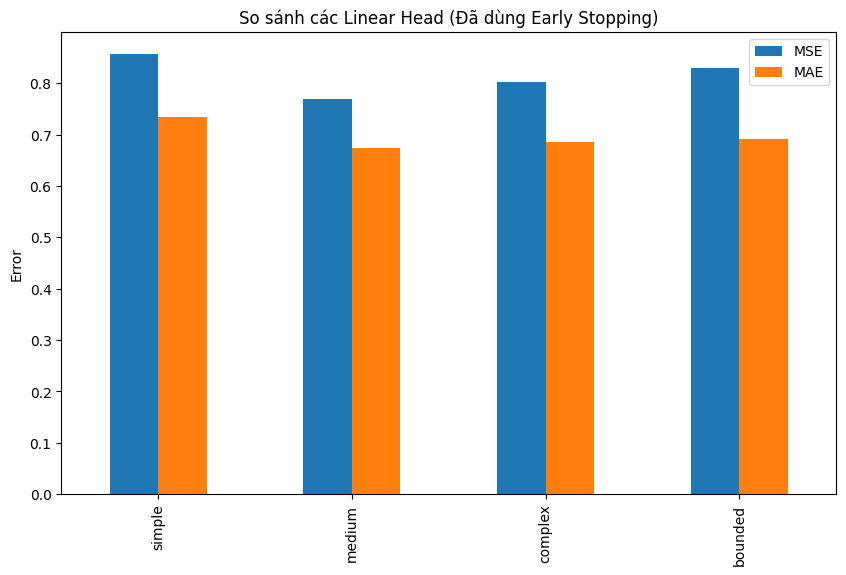

In [ ]:

head_types = ['simple', 'medium', 'complex', 'bounded']
results = {}
EPOCHS = 20  # Đặt số epoch lớn, Early Stopping sẽ tự cắt
PATIENCE = 3 # Nếu 3 vòng liên tiếp không tốt hơn thì dừng

print(f"{'='*10} BẮT ĐẦU THỬ NGHIỆM VỚI UNDERSAMPLING DATASET {'='*10}")
finetune_head_histories = {}
for head in head_types:
    print(f"\nDang train Head type: {head.upper()}...")
    
    # 1. Khởi tạo model
    model = BERTRegressor(head_type=head)
    model = model.to(device)
    
    # 2. Setup Loss, Optimizer và Early Stopping
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=0.001)
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=f'{head}_best_model_under.pt')
    
    train_losses = []
    val_losses = []

    # 3. Training Loop
    for epoch in range(EPOCHS):
        model.train()
        batch_losses = []
        for d in train_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            
            optimizer.zero_grad() # xoá các sai số gradient trước khi tính toán lại
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item()) # lưu giá trị loss
        
        avg_train_loss = np.mean(batch_losses) # tính loss trung bình cho epoch
        train_losses.append(avg_train_loss) # lưu loss trung bình cho epoch

        # VALIDATION
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader: 
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), targets)
                val_batch_losses.append(loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)

        print(f"  Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # GỌI EARLY STOPPING 
        early_stopping(avg_val_loss, model)
        
        if early_stopping.early_stop:
            print("  ==> Dừng sớm (Early Stopping)!")
            break
            
    # 4. Load lại model tốt nhất đã lưu để đánh giá cuối cùng
    # (Tránh trường hợp lấy model ở epoch cuối cùng vốn dĩ đang bị tệ đi)
    model.load_state_dict(torch.load(f'{head}_best_model_under.pt'))
    
    # Đánh giá lại lần cuối
    mse, mae, _, _ = evaluate_model(model, test_loader, device)
    results[head] = {'MSE': mse, 'MAE': mae, 'Best_Epoch': epoch - PATIENCE + 1}
    print(f"  => Kết quả cuối cùng {head}: MSE = {mse:.4f}")
        # Lưu lịch sử vào dict
    finetune_head_histories[head] = {'train_loss': train_losses, 'val_loss': val_losses}

# LƯU FILE JSON LỊCH SỬ LOSS
with open('finetune_head_histories.json', 'w') as f:
    json.dump(finetune_head_histories, f)
print("\n--- ĐÃ LƯU XONG MODEL VÀ LỊCH SỬ TRAINING ---")

# --- TỔNG KẾT ---
print(f"\n{'='*10} KẾT QUẢ SO SÁNH {'='*10}")
results_df = pd.DataFrame(results).T
print(results_df)

# Vẽ biểu đồ
results_df[['MSE', 'MAE']].plot(kind='bar', figsize=(10, 6))
plt.title('So sánh các Linear Head (Đã dùng Early Stopping)')
plt.ylabel('Error')
plt.show()

## Kết quả phương pháp undersampling và không dùng Concatenate

Đã load lịch sử huấn luyện thành công!
========== ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT ==========


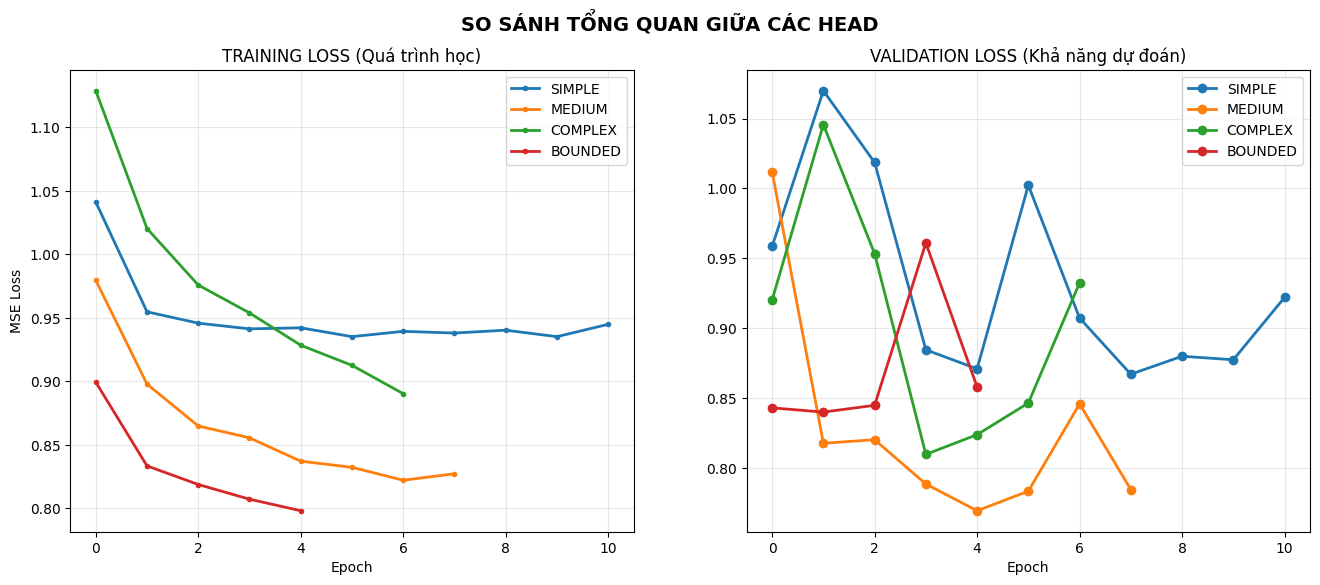

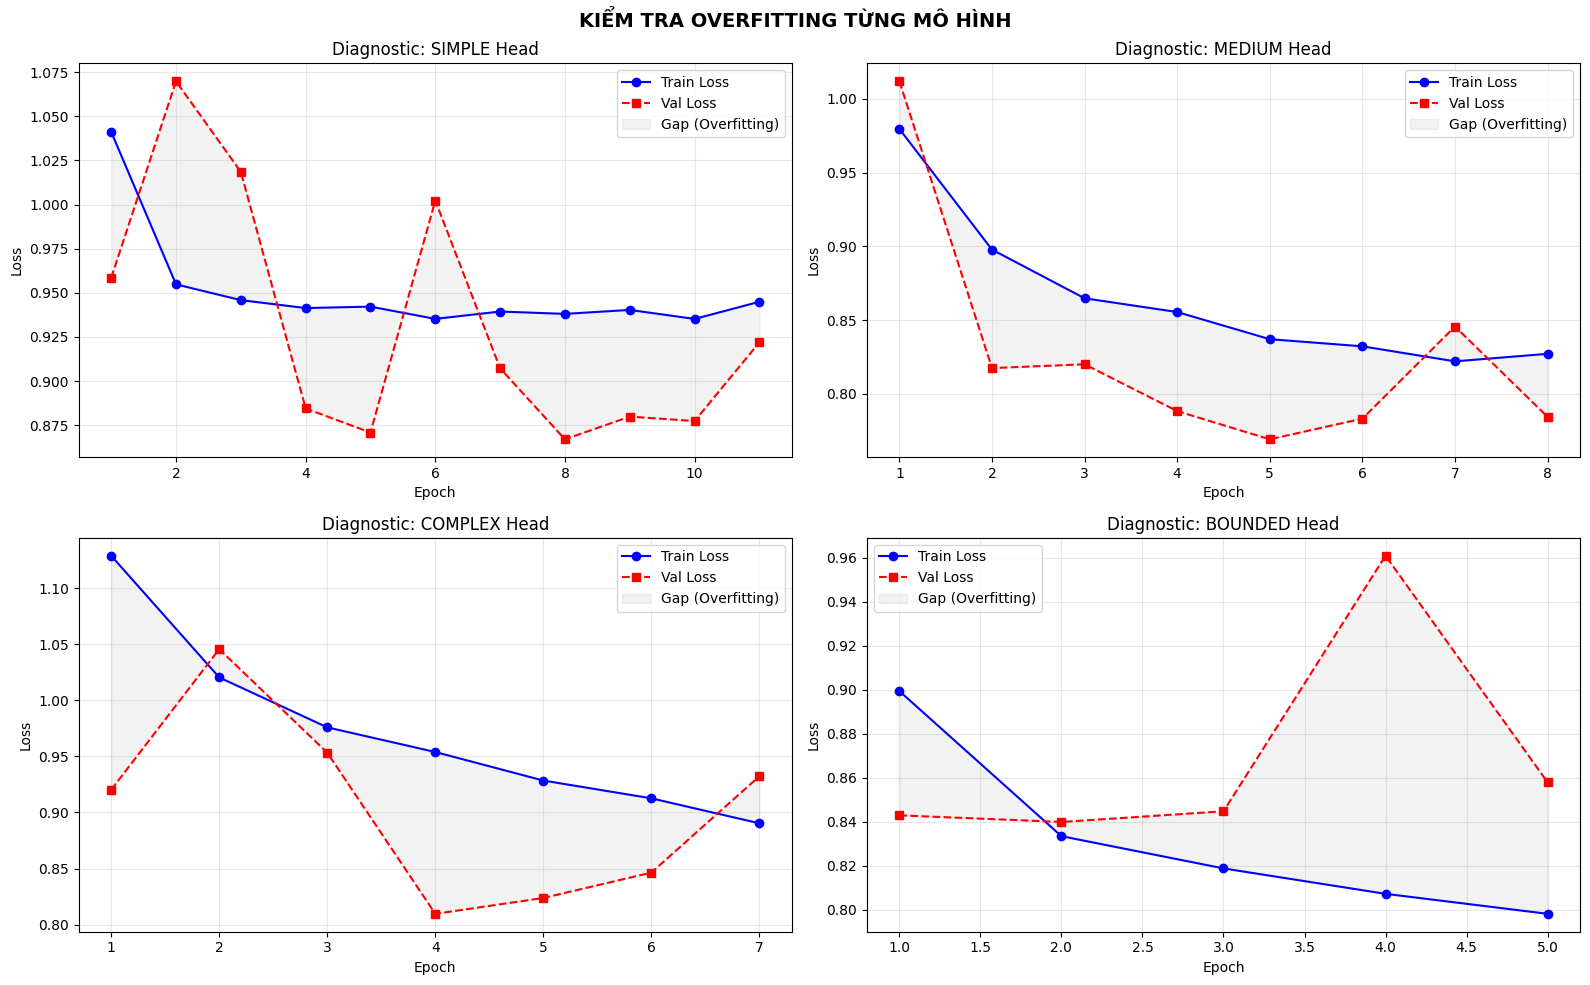


BẢNG XẾP HẠNG KẾT QUẢ TRAIN HEAD LAYER VỚI UNDERSAMPLING DATASET
      Head       MSE       MAE        R2  Accuracy
1   MEDIUM  0.769920  0.673215  0.581840  0.476878
2  COMPLEX  0.801548  0.685026  0.564662  0.471322
3  BOUNDED  0.829405  0.691187  0.549532  0.469554
0   SIMPLE  0.856436  0.734610  0.534851  0.416052


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#  DỮ LIỆU ĐÃ LƯU 
try:
    with open('finetune_head_histories.json', 'r') as f:
        histories = json.load(f)
    print("Đã load lịch sử huấn luyện thành công!")
except FileNotFoundError:
    print("CHƯA CÓ FILE LỊCH SỬ! Vui lòng chạy Cell Training trước.")

final_results = []
all_preds = {}

# ĐÁNH GIÁ MÔ HÌNH 
print(f"{'='*10} ĐÁNH GIÁ VÀ VẼ BIỂU ĐỒ CHI TIẾT {'='*10}")

for head in head_types:
    try:
        model = BERTRegressor(head_type=head).to(device)
        model.load_state_dict(torch.load(f'{head}_best_model_under.pt'))
        model.eval()
        
        preds, actuals = [], []
        with torch.no_grad():
            for d in test_loader:
                input_ids = d['input_ids'].to(device)
                mask = d['attention_mask'].to(device)
                targets = d['targets'].to(device)
                outputs = model(input_ids, mask)
                preds.extend(outputs.squeeze().tolist())
                actuals.extend(targets.tolist())
        
        mse = mean_squared_error(actuals, preds)
        mae = mean_absolute_error(actuals, preds)
        r2 = r2_score(actuals, preds)
        acc = np.mean(np.round(preds) == np.array(actuals))
        
        final_results.append({'Head': head.upper(), 'MSE': mse, 'MAE': mae, 'R2': r2, 'Accuracy': acc})
        all_preds[head] = {'actual': actuals, 'pred': preds}
    except:
        print(f"Lỗi load model {head}, bỏ qua đánh giá metrics...")




plt.rcParams.update({'font.size': 10})

#  SO SÁNH TỔNG QUAN (Train bên trái, Val bên phải)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Vẽ tất cả Train Loss
for head in head_types:
    if head in histories and len(histories[head]['train_loss']) > 0:
        axes[0].plot(histories[head]['train_loss'], label=f'{head.upper()}', marker='.', linewidth=2)
axes[0].set_title('TRAINING LOSS (Quá trình học)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Vẽ tất cả Val Loss
for head in head_types:
    if head in histories and len(histories[head]['val_loss']) > 0:
        axes[1].plot(histories[head]['val_loss'], label=f'{head.upper()}', marker='o', linewidth=2)
axes[1].set_title('VALIDATION LOSS (Khả năng dự đoán)')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle("SO SÁNH TỔNG QUAN GIỮA CÁC HEAD", fontsize=14, fontweight='bold')
plt.show()

# CHẨN ĐOÁN CHI TIẾT TỪNG MODEL (Train vs Val trên cùng 1 hình)
# Tạo lưới 2x2 để vẽ 4 biểu đồ con
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten() # Duỗi phẳng mảng axes để dễ loop

for i, head in enumerate(head_types):
    if head in histories and len(histories[head]['train_loss']) > 0:
        ax = axes[i]
        train_data = histories[head]['train_loss']
        val_data = histories[head]['val_loss']
        epochs = range(1, len(train_data) + 1)
        
        ax.plot(epochs, train_data, 'b-o', label='Train Loss')
        ax.plot(epochs, val_data, 'r--s', label='Val Loss')
        
        # Tô màu vùng chênh lệch (Gap) để thấy Overfitting
        ax.fill_between(epochs, train_data, val_data, color='gray', alpha=0.1, label='Gap (Overfitting)')
        
        ax.set_title(f'Diagnostic: {head.upper()} Head')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)

plt.suptitle("KIỂM TRA OVERFITTING TỪNG MÔ HÌNH", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

if final_results:
    df_res = pd.DataFrame(final_results).sort_values(by='MSE')
    print("\n" + "="*40)
    print("BẢNG XẾP HẠNG KẾT QUẢ TRAIN HEAD LAYER VỚI UNDERSAMPLING DATASET")
    print("="*40)
    print(df_res)

## TRAIN VỚI CONCATENATE

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertModel, BertConfig
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


class BERTRegressor_Concat(nn.Module):
    def __init__(self, head_type='simple'):
        super(BERTRegressor_Concat, self).__init__()
        
        # QUAN TRỌNG: Thêm output_hidden_states=True để lấy được các lớp ẩn
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        
        # Đóng băng BERT Backbone
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.head_type = head_type
        
        # Kích thước đầu vào mới: 768 * 4 = 3072
        input_dim = 768 * 4 
        
        if head_type == 'simple':
            self.regressor = nn.Linear(input_dim, 1)
            
        elif head_type == 'medium':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 256), # Input là 3072
                nn.ReLU(),
                nn.Linear(256, 1)
            )
            
        elif head_type == 'complex':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 512), # Input là 3072
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 128),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(128, 1)
            )
            
        elif head_type == 'bounded':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid()
            )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # outputs.hidden_states là một tuple chứa 13 layers (1 embedding + 12 layers)
        hidden_states = outputs.hidden_states
        
        # Lấy token [CLS] (vị trí 0) của 4 layer cuối cùng: -1, -2, -3, -4
        # Mỗi layer có shape: [batch_size, seq_len, 768] -> Lấy [:, 0, :] thành [batch_size, 768]
        cls_embeddings = [hidden_states[i][:, 0, :] for i in [-1, -2, -3, -4]]
        
        # Nối lại (Concatenate) theo chiều feature (dim=1)
        # Kết quả shape: [batch_size, 3072]
        concat_output = torch.cat(cls_embeddings, dim=1)
        
        # Đưa vào regressor head
        out = self.regressor(concat_output)
        
        if self.head_type == 'bounded':
            out = 1.0 + (out * 4.0)
            
        return out

In [5]:
def evaluate_model(model, data_loader, device):
    model.eval()
    predictions = []
    real_values = []
    
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            predictions.extend(outputs.squeeze().tolist())
            real_values.extend(targets.tolist())
            
    mse = mean_squared_error(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions)
    # Tính thêm R2 để đánh giá độ khớp tổng thể
    r2 = r2_score(real_values, predictions) 
    
    return mse, mae, r2, real_values, predictions

# --- CONFIG ---
head_types = ['simple', 'medium', 'complex', 'bounded']
results = {}
EPOCHS = 20  
PATIENCE = 3 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"{'='*10} BẮT ĐẦU THỬ NGHIỆM VỚI CONCATENATE 4 LAYERS {'='*10}")
finetune_head_histories = {}

for head in head_types:
    print(f"\nDang train Head type: {head.upper()} (Input: 3072 dims)...")
    
    # 1. Khởi tạo model mới
    model = BERTRegressor_Concat(head_type=head)
    model = model.to(device)
    
    # 2. Setup Loss, Optimizer
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=0.001)
    
    # SỬA TÊN FILE LƯU: _concat.pt
    save_path = f'{head}_best_model_concat.pt'
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=save_path)
    
    train_losses = []
    val_losses = []

    # 3. Training Loop
    for epoch in range(EPOCHS):
        model.train()
        batch_losses = []
        for d in train_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.squeeze(), targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # VALIDATION
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader: 
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.squeeze(), targets)
                val_batch_losses.append(loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)

        print(f"  Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Early Stopping
        early_stopping(avg_val_loss, model)
        
        if early_stopping.early_stop:
            print("  ==> Dừng sớm (Early Stopping)!")
            break
            
    # 4. Load lại model tốt nhất và đánh giá
    model.load_state_dict(torch.load(save_path))
    
    # Đánh giá metrics đầy đủ
    mse, mae, r2, _, _ = evaluate_model(model, test_loader, device)
    results[head] = {'MSE': mse, 'MAE': mae, 'R2': r2, 'Best_Epoch': epoch - PATIENCE + 1}
    print(f"  => Kết quả cuối cùng {head}: MSE = {mse:.4f}")
    
    finetune_head_histories[head] = {'train_loss': train_losses, 'val_loss': val_losses}

# LƯU FILE JSON LỊCH SỬ MỚI
with open('finetune_head_histories_concat.json', 'w') as f:
    json.dump(finetune_head_histories, f)

print("\n--- ĐÃ LƯU XONG MODEL VÀ LỊCH SỬ TRAINING (CONCAT VERSION) ---")

========== BẮT ĐẦU THỬ NGHIỆM VỚI CONCATENATE 4 LAYERS ==========

Dang train Head type: SIMPLE (Input: 3072 dims)...
  Epoch 1/20 | Train Loss: 1.0157 | Val Loss: 0.9245
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.9514 | Val Loss: 0.8132
Loss giam. Luu model...
  Epoch 3/20 | Train Loss: 0.9377 | Val Loss: 0.8378
EarlyStopping: 1/3
  Epoch 4/20 | Train Loss: 0.9365 | Val Loss: 0.9065
EarlyStopping: 2/3
  Epoch 5/20 | Train Loss: 0.9381 | Val Loss: 0.7721
Loss giam. Luu model...
  Epoch 6/20 | Train Loss: 0.9221 | Val Loss: 0.8336
EarlyStopping: 1/3
  Epoch 7/20 | Train Loss: 0.9185 | Val Loss: 0.8782
EarlyStopping: 2/3
  Epoch 8/20 | Train Loss: 0.9314 | Val Loss: 0.8030
EarlyStopping: 3/3
  ==> Dừng sớm (Early Stopping)!
  => Kết quả cuối cùng simple: MSE = 0.7838

Dang train Head type: MEDIUM (Input: 3072 dims)...
  Epoch 1/20 | Train Loss: 0.9592 | Val Loss: 0.8108
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.8629 | Val Loss: 0.8311
EarlyStopping: 1/3
  Epoch 3/20 

## Kết quả phương pháp concatenate + undersampling


========== BẢNG TỔNG HỢP KẾT QUẢ (CONCATENATE) ==========
              MSE       MAE        R2  Best_Epoch
medium   0.721292  0.657996  0.608333         3.0
complex  0.760565  0.677602  0.587008         7.0
simple   0.783822  0.701493  0.574379         5.0
bounded  0.790889  0.656817  0.570541         2.0


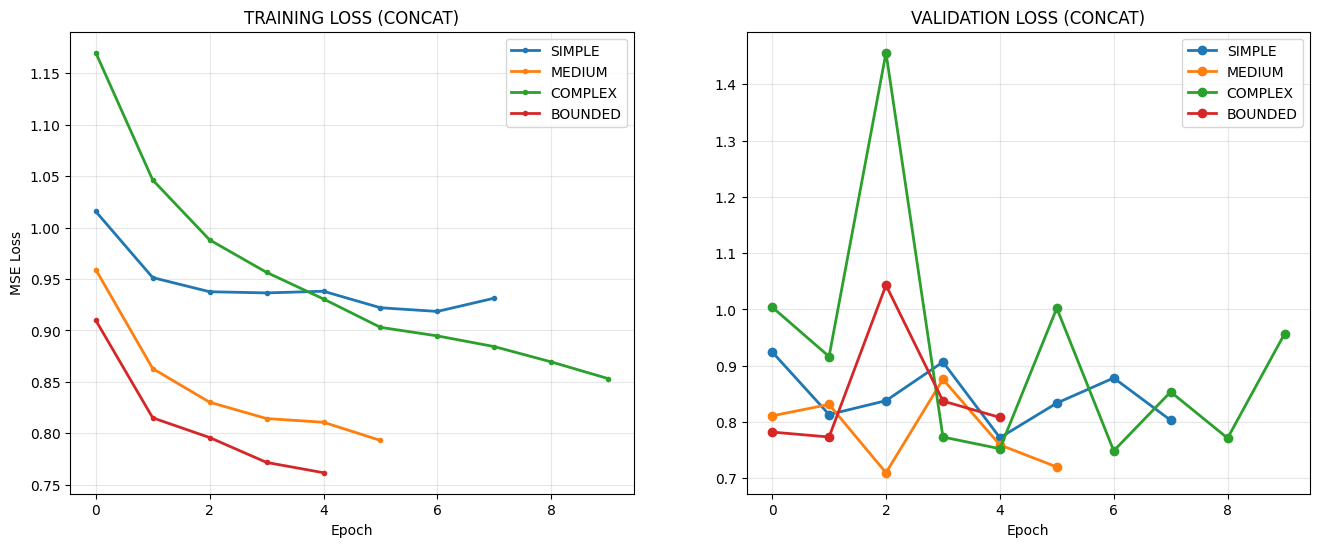


Đang vẽ biểu đồ phân tán cho model tốt nhất: MEDIUM


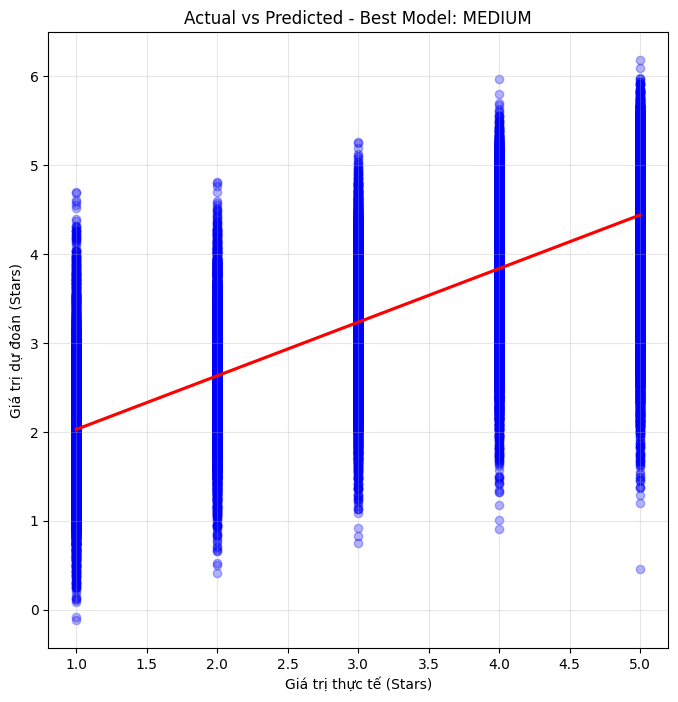


=== BẢNG XẾP HẠNG CUỐI CÙNG ===
              MSE       MAE        R2  Best_Epoch
medium   0.721292  0.657996  0.608333         3.0
complex  0.760565  0.677602  0.587008         7.0
simple   0.783822  0.701493  0.574379         5.0
bounded  0.790889  0.656817  0.570541         2.0


In [6]:
# --- TỔNG KẾT VÀ VẼ BIỂU ĐỒ ---
print(f"\n{'='*10} BẢNG TỔNG HỢP KẾT QUẢ (CONCATENATE) {'='*10}")
results_df = pd.DataFrame(results).T
print(results_df.sort_values(by='MSE'))

# Load lại history để vẽ
with open('finetune_head_histories_concat.json', 'r') as f:
    histories = json.load(f)

# --- VẼ BIỂU ĐỒ LOSS ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Train Loss
for head in head_types:
    if head in histories and len(histories[head]['train_loss']) > 0:
        axes[0].plot(histories[head]['train_loss'], label=f'{head.upper()}', marker='.', linewidth=2)
axes[0].set_title('TRAINING LOSS (CONCAT)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 2. Val Loss
for head in head_types:
    if head in histories and len(histories[head]['val_loss']) > 0:
        axes[1].plot(histories[head]['val_loss'], label=f'{head.upper()}', marker='o', linewidth=2)
axes[1].set_title('VALIDATION LOSS (CONCAT)')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.show()

# --- VẼ BIỂU ĐỒ ACTUAL vs PREDICTED CHO MODEL TỐT NHẤT ---
# Tìm model có MSE thấp nhất
best_head_name = min(results, key=lambda k: results[k]['MSE'])
print(f"\nĐang vẽ biểu đồ phân tán cho model tốt nhất: {best_head_name.upper()}")

model = BERTRegressor_Concat(head_type=best_head_name).to(device)
model.load_state_dict(torch.load(f'{best_head_name}_best_model_concat.pt'))
_, _, _, real_vals, pred_vals = evaluate_model(model, test_loader, device)

plt.figure(figsize=(8, 8))
sns.regplot(x=np.array(real_vals), y=np.array(pred_vals), 
            scatter_kws={'alpha':0.3, 'color':'blue'}, line_kws={'color':'red'})
plt.xlabel('Giá trị thực tế (Stars)')
plt.ylabel('Giá trị dự đoán (Stars)')
plt.title(f'Actual vs Predicted - Best Model: {best_head_name.upper()}')
plt.grid(True, alpha=0.3)
plt.show()

# Hiển thị bảng kết quả cuối cùng đẹp hơn
final_df = pd.DataFrame(results).T
final_df = final_df[['MSE', 'MAE', 'R2', 'Best_Epoch']].sort_values(by='MSE')
print("\n=== BẢNG XẾP HẠNG CUỐI CÙNG ===")
print(final_df)

## TRAINING VỚI Phương pháp class weight + concatenate (Tập dữ liệu mất cân bằng gốc)

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_len=128, is_train=False): 
        # 1. Đọc và làm sạch dữ liệu
        self.df = pd.read_csv(csv_file)
        self.df = self.df.dropna(subset=['clean_text', 'stars'])
        
        # QUAN TRỌNG: Reset index sau khi dropna để tránh lỗi khi dùng __getitem__
        self.df = self.df.reset_index(drop=True) 
        
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.is_train = is_train
        
        # 2. Tự động tính toán trọng số (chỉ cho tập Train)
        self.weights_map = {}
        if self.is_train:
            self.weights_map = self.calculate_weights()
            print(f"--> Đã tính trọng số cho {csv_file}: {self.weights_map}")

    def calculate_weights(self):
        # Đếm số lượng mỗi nhãn
        counts = self.df['stars'].value_counts().to_dict()
        total_samples = len(self.df)
        num_classes = len(counts)
        
        # Công thức: weight = total / (num_classes * count)
        # Giúp cân bằng sự đóng góp của các class ít vào Loss
        weights = {}
        for score, count in counts.items():
            weights[float(score)] = total_samples / (num_classes * count)
        return weights

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        # Sử dụng iloc hoặc loc an toàn sau khi đã reset_index
        text = str(self.df.loc[index, 'clean_text'])
        score = float(self.df.loc[index, 'stars'])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        # 3. Lấy trọng số tương ứng (Mặc định là 1.0 nếu là Test/Val hoặc nhãn lạ)
        # Nếu là tập Train -> lấy từ weights_map, Nếu Test/Val -> luôn là 1.0
        sample_weight = self.weights_map.get(score, 1.0) if self.is_train else 1.0

        return { 
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(score, dtype=torch.float),
            'weight': torch.tensor(sample_weight, dtype=torch.float) # <--- Trả về trọng số
        }

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


# Tập Train: is_train=True để tính trọng số cân bằng
train_dataset = ReviewDataset('trains.csv', tokenizer, is_train=True) # Sửa tên file csv cho đúng

# Tập Test/Val: is_train=False (Không cần cân bằng trọng số khi đánh giá)
test_dataset = ReviewDataset('test.csv', tokenizer, is_train=False)
val_dataset = ReviewDataset('val.csv', tokenizer, is_train=False) 

# DataLoader: Thêm drop_last=True cho train để tránh lỗi BatchNorm nếu dùng
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

c:\activities\DLProject\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda
--> Đã tính trọng số cho trains.csv: {5.0: 0.44982311700006433, 4.0: 0.7938475509393269, 3.0: 1.7657871480873628, 1.0: 1.8255955100176207, 2.0: 2.4805888090804293}


In [11]:
import torch
import torch.nn as nn
from transformers import BertModel
class BERTRegressor_head(nn.Module):
    def __init__(self, head_type='simple'):
        super(BERTRegressor_head, self).__init__()
        
        # 1. Bật output_hidden_states để lấy được các layer bên trong
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        
        # Đóng băng BERT (Fine-tining phần Head thôi)
        for param in self.bert.parameters():
            param.requires_grad = False
            
        self.head_type = head_type
        
        # --- CẤU HÌNH KÍCH THƯỚC MỚI ---
        # 768 (kích thước gốc) * 4 (số layer) = 3072
        input_dim = 768 * 4 
        
        # Dùng LayerNorm để chuẩn hóa đầu vào 3072 chiều (An toàn hơn BatchNorm với batch nhỏ)
        self.ln = nn.LayerNorm(input_dim)

        # Định nghĩa các Head với input_dim = 3072
        if head_type == 'simple':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 1)
            )
            
        elif head_type == 'medium':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 512),
                nn.LayerNorm(512),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(512, 1)
            )
            
        elif head_type == 'complex':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 1024),
                nn.LayerNorm(1024),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(1024, 256),
                nn.LayerNorm(256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, 1)
            )
            
        elif head_type == 'bounded':
            self.regressor = nn.Sequential(
                nn.Linear(input_dim, 256),
                nn.ReLU(),
                nn.Linear(256, 1),
                nn.Sigmoid() 
            )

    def forward(self, input_ids, attention_mask):
        # --- BƯỚC 1: CHẠY QUA BERT ---
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # --- BƯỚC 2: KỸ THUẬT CONCATENATE 4 LAYERS ---
        # outputs.hidden_states là tuple gồm 13 lớp (1 embedding + 12 layers)
        hidden_states = outputs.hidden_states
        
        # Lấy token [CLS] (vị trí 0) từ 4 lớp cuối cùng: -1, -2, -3, -4
        # Mỗi layer có shape: (Batch_Size, Sequence_Len, 768)
        # Lấy [:, 0, :] sẽ được: (Batch_Size, 768)
        
        # Lưu ý: hidden_states[-1] là lớp cuối cùng (lớp 12)
        cls_embeddings = [hidden_states[i][:, 0, :] for i in [-1, -2, -3, -4]]
        
        # Nối lại theo chiều dọc (dim=1)
        # Kết quả: (Batch_Size, 768 * 4) -> (Batch_Size, 3072)
        embedding = torch.cat(cls_embeddings, dim=1)

        # --- BƯỚC 3: CHUẨN HÓA VÀ ĐƯA VÀO HEAD ---
        embedding = self.ln(embedding) # LayerNorm cực kỳ quan trọng khi nối vector lớn
        out = self.regressor(embedding)

        if self.head_type == 'bounded':
            out = 1.0 + (out * 4.0)

        return out

In [ ]:
# --- 3. HÀM TRAIN & EVALUATE ---

def train_head_only(model, data_loader, criterion, optimizer, device):
    model.train() # đặt mô hình ở chế độ train
    losses = []
    for d in data_loader:
        input_ids = d["input_ids"].to(device) # chuyển dữ liệu sang device (CPU hoặc GPU)
        attention_mask = d["attention_mask"].to(device) # chuyển dữ liệu sang device (CPU hoặc GPU)
        targets = d["targets"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        # Flatten outputs để khớp kích thước với targets
        loss = criterion(outputs.squeeze(), targets) 
        losses.append(loss.item()) # lưu giá trị loss

        optimizer.zero_grad() # xoá các sai số gradient trước khi tính toán lại
        loss.backward() # lan truyền ngược để tính toán gradient
        optimizer.step() # cập nhật trọng số mô hình
    return np.mean(losses)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, data_loader, device):
    model.eval() # đặt mô hình ở chế độ đánh giá
    predictions = [] 
    real_values = []
    
    with torch.no_grad(): # không tính toán gradient
        for d in data_loader:
            input_ids = d["input_ids"].to(device) 
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Model tự động nối 4 layers bên trong
            outputs = model(input_ids=input_ids, attention_mask=attention_mask) 
            
            predictions.extend(outputs.squeeze().tolist())  # lưu dự đoán
            real_values.extend(targets.tolist())    # lưu thực tế
            
    # Tính toán các chỉ số
    mse = mean_squared_error(real_values, predictions)
    mae = mean_absolute_error(real_values, predictions)
    r2 = r2_score(real_values, predictions)
    
    # Trả về 5 giá trị để khớp với dòng gọi hàm ở code chính
    return mse, mae, r2, real_values, predictions

In [13]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import json
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Early Stopping 
class EarlyStopping:
    def __init__(self, patience=3, verbose=False, path='checkpoint.pt'):
        self.patience = patience # số epoch chờ đợi trước khi dừng
        self.verbose = verbose # in thông báo debug
        self.counter = 0 # đếm số epoch không cải thiện
        self.best_score = None # Lưu điểm số tốt nhất tính từ lúc train đến hiện tại
        self.early_stop = False # cờ dừng sớm
        self.val_loss_min = np.inf # giá trị loss tối thiểu ban đầu
        self.path = path # đường dẫn lưu mô hình

    def __call__(self, val_loss, model):
        score = -val_loss # điểm số là âm của loss (giá trị càng cao càng tốt)
        if self.best_score is None:
            self.best_score = score # khởi tạo best_score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score: # không cải thiện
            self.counter += 1 # tăng bộ đếm
            if self.verbose: print(f'EarlyStopping: {self.counter}/{self.patience}')
            if self.counter >= self.patience: self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose: print(f'Loss giam. Luu model...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


In [14]:
# --- CẤU HÌNH VÀ CHẠY ---
head_types = ['simple', 'medium', 'complex', 'bounded']
results = {}
history = {} 
EPOCHS = 20  
PATIENCE = 3 

print(f"{'='*10} BẮT ĐẦU THÍ NGHIỆM VỚI WEIGHTED LOSS & EARLY STOPPING {'='*10}")

for head in head_types:
    print(f"\nDang train Head type: {head.upper()}...")
    
    # 1. Khởi tạo model
    # Lưu ý: Class này phải là class BERTRegressor_head (có concat 4 layers) mà tôi đưa ở bước trước
    model = BERTRegressor_head(head_type=head) 
    model = model.to(device)
    
    # 2. Setup Loss reduction='none' để nhân trọng số thủ công
    criterion = nn.HuberLoss(delta=1.0, reduction='none') 
    
    optimizer = torch.optim.Adam(model.regressor.parameters(), lr=0.0001) 
    
    # Khởi tạo Early Stopping
    early_stopping = EarlyStopping(patience=PATIENCE, verbose=True, path=f'{head}_best_model_cw.pt')
    
    train_losses = []
    val_losses = []

    # 3. Training Loop
    for epoch in range(EPOCHS):
        # --- TRAIN ---
        model.train()
        batch_losses = []
        
        for d in train_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            weights = d["weight"].to(device) # Lấy trọng số từ DataLoader
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Tính Loss vector
            raw_loss = criterion(outputs.squeeze(), targets)
            
            # Nhân trọng số rồi mới tính Mean
            loss = (raw_loss * weights).mean() 
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())
        
        avg_train_loss = np.mean(batch_losses)
        train_losses.append(avg_train_loss)

        # --- VALIDATION ---
        model.eval()
        val_batch_losses = []
        with torch.no_grad():
            for d in val_loader: 
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                targets = d["targets"].to(device)
                
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                
                # Validation không nhân weight để đánh giá công bằng
                val_loss_vector = criterion(outputs.squeeze(), targets)
                val_loss = val_loss_vector.mean() 
                
                val_batch_losses.append(val_loss.item())
        
        avg_val_loss = np.mean(val_batch_losses)
        val_losses.append(avg_val_loss)

        print(f"  Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

        # Check Early Stopping
        early_stopping(avg_val_loss, model)
        if early_stopping.early_stop:
            print("  ==> Dừng sớm (Early Stopping)!")
            break
    
    # Lưu lịch sử
    history[head] = {
        'train': train_losses,
        'val': val_losses
    }

    # 4. Đánh giá model tốt nhất
    # Load lại weight tốt nhất đã lưu
    model.load_state_dict(torch.load(f'{head}_best_model_cw.pt'))
    
    # Gọi hàm evaluate_model (đã sửa ở trên)
    mse, mae, r2, _, _ = evaluate_model(model, test_loader, device)
    
    results[head] = {
        'MSE': mse, 
        'MAE': mae, 
        'R2': r2, 
        'Best_Epoch': epoch - PATIENCE + 1
    }
    print(f"  => Kết quả cuối {head}: MSE={mse:.4f}, R2={r2:.4f}")

========== BẮT ĐẦU THÍ NGHIỆM VỚI WEIGHTED LOSS & EARLY STOPPING ==========

Dang train Head type: SIMPLE...
  Epoch 1/20 | Train Loss: 0.4225 | Val Loss: 0.4011
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.3839 | Val Loss: 0.3984
Loss giam. Luu model...
  Epoch 3/20 | Train Loss: 0.3778 | Val Loss: 0.3824
Loss giam. Luu model...
  Epoch 4/20 | Train Loss: 0.3735 | Val Loss: 0.3754
Loss giam. Luu model...
  Epoch 5/20 | Train Loss: 0.3719 | Val Loss: 0.3398
Loss giam. Luu model...
  Epoch 6/20 | Train Loss: 0.3705 | Val Loss: 0.3534
EarlyStopping: 1/3
  Epoch 7/20 | Train Loss: 0.3679 | Val Loss: 0.3441
EarlyStopping: 2/3
  Epoch 8/20 | Train Loss: 0.3666 | Val Loss: 0.3970
EarlyStopping: 3/3
  ==> Dừng sớm (Early Stopping)!
  => Kết quả cuối simple: MSE=0.7850, R2=0.5738

Dang train Head type: MEDIUM...
  Epoch 1/20 | Train Loss: 0.3967 | Val Loss: 0.3328
Loss giam. Luu model...
  Epoch 2/20 | Train Loss: 0.3592 | Val Loss: 0.3437
EarlyStopping: 1/3
  Epoch 3/20 | Train Loss: 

## Kết quả phương pháp class weight + concatenate

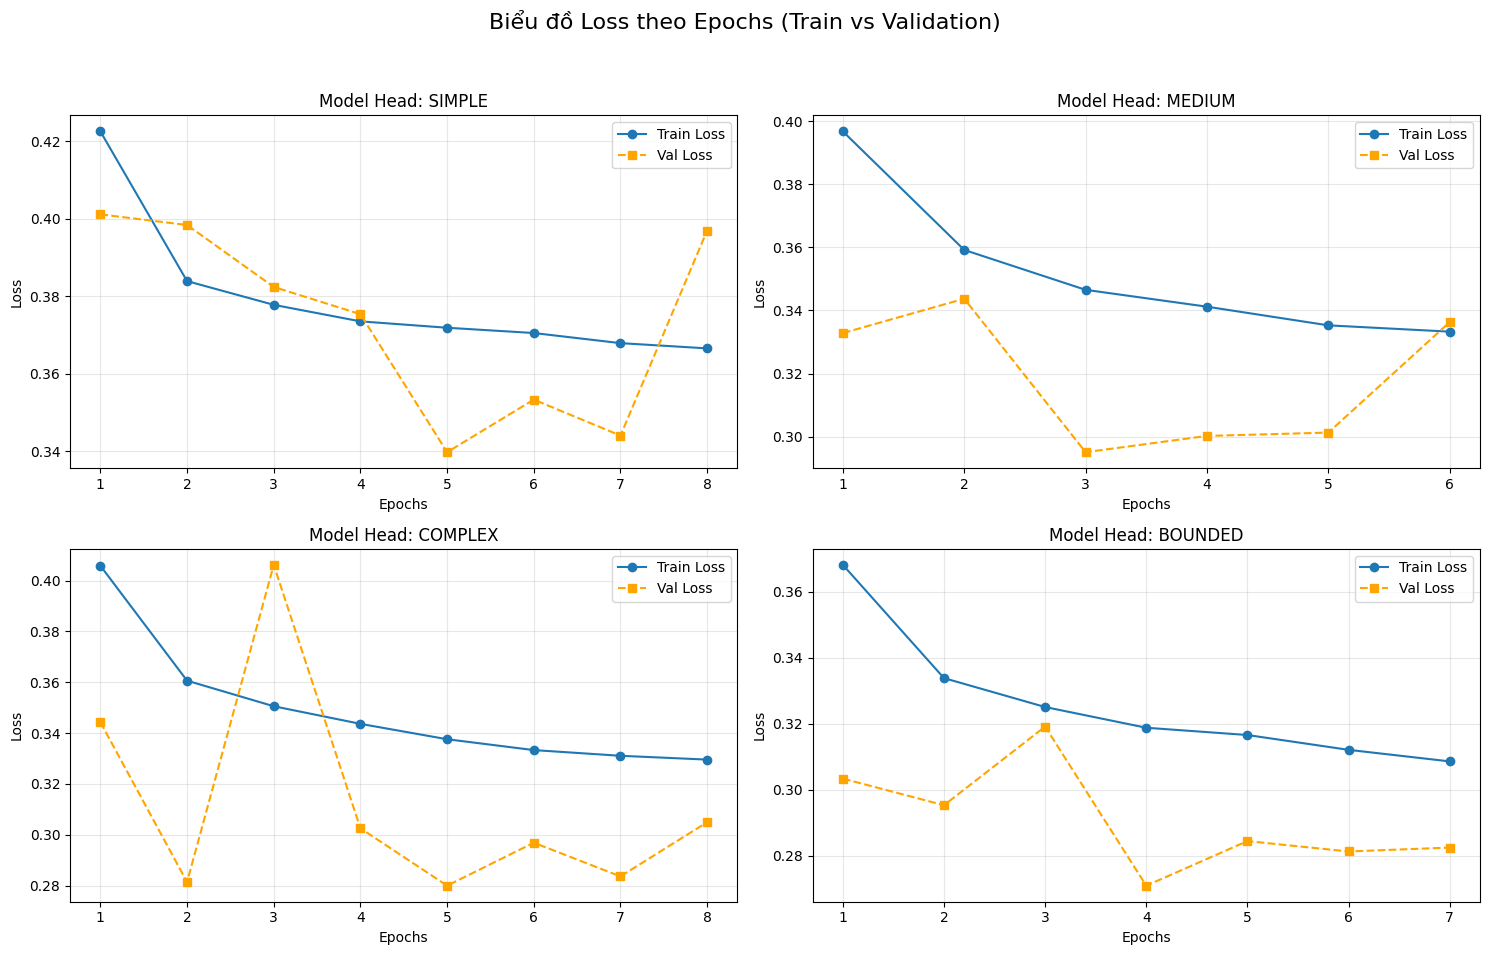


========== BẢNG TỔNG HỢP KẾT QUẢ ==========
              MSE       MAE        R2  Best_Epoch
simple   0.784962  0.697844  0.573760         5.0
medium   0.693041  0.636946  0.623674         3.0
complex  0.676236  0.619954  0.632799         5.0
bounded  0.641187  0.585868  0.651831         4.0


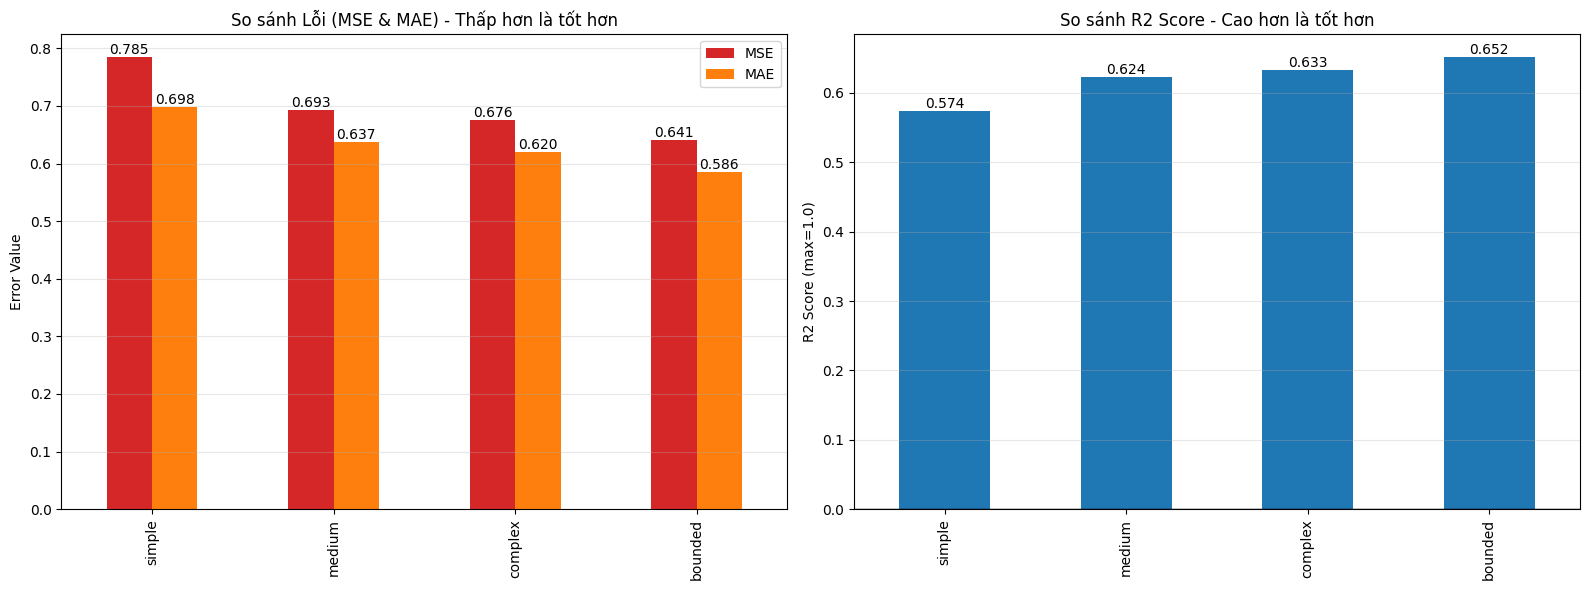

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import json
# --- VẼ BIỂU ĐỒ LOSS (Train vs Val) ---
fig, axes = plt.subplots(2, 2, figsize=(15, 10)) # Lưới 2x2 cho 4 heads
fig.suptitle('Biểu đồ Loss theo Epochs (Train vs Validation)', fontsize=16)
axes = axes.flatten()

for i, head in enumerate(head_types):
    ax = axes[i]
    # Lấy dữ liệu
    t_loss = history[head]['train']
    v_loss = history[head]['val']
    epochs_range = range(1, len(t_loss) + 1)
    
    # Vẽ
    ax.plot(epochs_range, t_loss, label='Train Loss', marker='o', linestyle='-')
    ax.plot(epochs_range, v_loss, label='Val Loss', marker='s', linestyle='--', color='orange')
    
    ax.set_title(f'Model Head: {head.upper()}')
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- VẼ BIỂU ĐỒ METRICS (MSE & R2) ---
print(f"\n{'='*10} BẢNG TỔNG HỢP KẾT QUẢ {'='*10}")
results_df = pd.DataFrame(results).T
print(results_df)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Biểu đồ MSE & MAE (Càng thấp càng tốt)
results_df[['MSE', 'MAE']].plot(kind='bar', ax=ax1, color=['#d62728', '#ff7f0e'])
ax1.set_title('So sánh Lỗi (MSE & MAE) - Thấp hơn là tốt hơn')
ax1.set_ylabel('Error Value')
ax1.grid(axis='y', alpha=0.3)
for container in ax1.containers:
    ax1.bar_label(container, fmt='%.3f')

# Biểu đồ R2 Score (Càng cao càng tốt)
results_df['R2'].plot(kind='bar', ax=ax2, color='#1f77b4')
ax2.set_title('So sánh R2 Score - Cao hơn là tốt hơn')
ax2.set_ylabel('R2 Score (max=1.0)')
ax2.set_ylim(bottom=0) # Hoặc set (-1, 1) nếu R2 bị âm
ax2.grid(axis='y', alpha=0.3)
ax2.axhline(0, color='black', linewidth=1) # Đường kẻ ngang mức 0
for container in ax2.containers:
    ax2.bar_label(container, fmt='%.3f')

plt.tight_layout()
plt.show()